In [1]:
# Libraries
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler, RobustScaler

from torch.utils.data import DataLoader, random_split
import pandas as pd
import os, re, struct, socket, csv
from collections import deque


import import_ipynb
import project_models


importing Jupyter notebook from project_models.ipynb


In [2]:
#GPU Checking
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

#device = torch.device("cpu")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

Using GPU: NVIDIA GeForce RTX 3060 Ti


Data Preprocessing

In [3]:
## Creating a Combined dataset
#directory = 'data/TrafficLabelling'
#full_dataset = pd.DataFrame()

#for file in os.listdir(directory):
#    file_path = os.path.join(directory, file)
#    df = pd.read_csv(file_path)
#    full_dataset = pd.concat([full_dataset, df], axis=0)  # Stack vertically

#full_dataset.to_csv('full_dataset.csv')


In [4]:
# Helper function to convert IP addresses into integers
def encode_ip(ip_address):
    try:
        return struct.unpack("!L", socket.inet_aton(ip_address))[0]
    except socket.error:
        # Handle the case for invalid IP addresses
        return 0

Custom Dataset Construction

In [5]:
from datetime import datetime

class NetworkDataset(Dataset):
    def __init__(self, file_path, seq_duration=5, time_unit='minute', num_entries=None, window_size=50, decay=0.9):
        self.window_size = window_size
        self.decay = decay
        self.data = self.load_and_process_data(file_path, num_entries)
        self.seq_duration = seq_duration
        self.time_unit = time_unit
        self.seq_length = self.calculate_sequence_length()
        self.scale_features()

    def load_and_process_data(self, file_path, num_entries):
        data = []
        with open(file_path, 'r') as file:
            reader = csv.DictReader(file)
            reader.fieldnames = [column.strip() for column in reader.fieldnames] # Removes Whitespace from headernames
            
            rolling_stats = {
                'Packet Length Mean': deque(maxlen=self.window_size),
                'Packet Length Std': deque(maxlen=self.window_size),
                #'Packet Length Max': deque(maxlen=self.window_size),  # If you decide it should be a rolling metric
                #'SYN Flag Count': deque(maxlen=self.window_size),     # If rolling count is needed
            }
            ema_packet_size = 0

            for i, row in enumerate(reader):
                if num_entries is not None and i >= num_entries:
                    break
                try:
                    processed_row = self.preprocess_data(row, rolling_stats, ema_packet_size)
                    ema_packet_size = processed_row['EMA_Packet_Size']
                    data.append(processed_row)
                except ValueError as e:
                    print(f"Error processing row {i}: {e}")
                    continue #Skip or Stop
        return data
    
    def update_rolling_stats(self, rolling_stats, numeric_fields, processed_row):
        for key in ['Packet Length Mean', 'Packet Length Std',]: #'Packet Length Max', 'SYN Flag Count']:
            rolling_stats[key].append(numeric_fields[key])
            processed_row[f'Rolling_{key}'] = sum(rolling_stats[key]) / len(rolling_stats[key])

    def preprocess_data(self, row, rolling_stats, prev_ema_packet_size):
        # Preprocess and encode features
        processed_row = {}
        
        # Add the 'Timestamp' column
        processed_row['Timestamp'] = row['Timestamp']

        # Categorical Encoding
        processed_row['source_encoded'] = encode_ip(row['Source IP'])
        processed_row['destination_encoded'] = encode_ip(row['Destination IP'])
        processed_row['Protocol'] = row['Protocol']

        # Numeric fields
        numeric_fields = {
            'Flow Duration': float(row.get('Flow Duration', 0)),
            'Total Fwd Packets': float(row.get('Total Fwd Packets', 0)),
            'Total Backward Packets': float(row.get('Total Backward Packets', 0)),
            'Total Length of Fwd Packets': float(row.get('Total Length of Fwd Packets', 0)),
            'Total Length of Bwd Packets': float(row.get('Total Length of Bwd Packets', 0)),
            'Packet Length Mean': float(row.get('Packet Length Mean', 0)),
            'Packet Length Std': float(row.get('Packet Length Std', 0)),
            'Flow Bytes/s': float(row.get('Flow Bytes/s', 0) if row['Flow Bytes/s'] not in ['', None] else 0.0),
        }

        # Use numeric_fields for calculations
        processed_row.update(numeric_fields)

        try:
            processed_row['Fwd_to_Bwd_Packets'] = numeric_fields['Total Fwd Packets'] / (numeric_fields['Total Backward Packets'] + 0.001)
            processed_row['Fwd_to_Bwd_Bytes'] = numeric_fields['Total Length of Fwd Packets'] / (numeric_fields['Total Length of Bwd Packets'] + 0.001)
        except ZeroDivisionError:
            processed_row['Fwd_to_Bwd_Packets'] = 0.0
            processed_row['Fwd_to_Bwd_Bytes'] = 0.0

        # Rolling and EMA Calcs
        self.update_rolling_stats(rolling_stats, numeric_fields, processed_row)
        ema_packet_size = self.decay * prev_ema_packet_size + (1 - self.decay) * numeric_fields['Packet Length Mean']
        processed_row['EMA_Packet_Size'] = ema_packet_size

        #Calculations
        total_length = numeric_fields['Total Length of Fwd Packets'] + numeric_fields['Total Length of Bwd Packets']
        processed_row['Total Length'] = total_length

        try:
            processed_row['Bandwidth'] = total_length / (numeric_fields['Flow Duration'] / 1000000.0)
            processed_row['Throughput'] = (numeric_fields['Total Fwd Packets'] + numeric_fields['Total Backward Packets']) / (numeric_fields['Flow Duration'] / 1000000.0)
            processed_row['Latency'] = numeric_fields['Flow Duration'] / 1000000.0
        except ZeroDivisionError:
            processed_row['Bandwidth'] = 0.0
            processed_row['Throughput'] = 0.0
            processed_row['Latency'] = 0.0

        processed_row['Label'] = 0 if row['Label'] == 'BENIGN' else 1

        # Check for NaNs in numeric fields only
        #numeric_values = np.array(list(numeric_fields.values()), dtype=np.float32)
        #if np.isnan(numeric_values).any():
        #    print("NaN found after processing a row:", processed_row)

        return processed_row
    

    def scale_features(self):
        # Scale model input features
        features_to_scale = ['Bandwidth', 'Throughput', 'Latency', 'Flow Duration', 
            'Fwd_to_Bwd_Packets', 'Fwd_to_Bwd_Bytes', 'Rolling_Mean_Packet_Size', 
            'Rolling_Std_Packet_Size', 'Total Length', 'EMA_Packet_Size', 
            'Rolling_Max_Packet_Size', 'Rolling_SYN_Flag_Count']
        
        # Creating a list to hold all features
        features = []
        for row in self.data:
            row_features = []
            for feature in features_to_scale:
                value = row.get(feature, 0)  # Default to 0 if feature is missing
                row_features.append(value)
            features.append(row_features)

        features = np.array(features, dtype=np.float32)
        features = np.where(np.isnan(features), np.mean(features, axis=0), features)  # Impute NaNs with column mean

        # Apply robust scaling
        scaler = RobustScaler()
        scaled_features = scaler.fit_transform(features)
        
        for i, row in enumerate(self.data):
            for j, feature in enumerate(features_to_scale):
                row[feature] = scaled_features[i][j]


    def get_data(self):
        return self.data


    def __len__(self):
        return len(self.data)
    

    def calculate_sequence_length(self):
        # Generalize time unit handling using a dictionary
        time_units = {
            'second': 'seconds',
            'minute': 'minutes',
            'hour': 'hours',
            'day': 'days'
        }

        if self.time_unit not in time_units:
            raise ValueError(f"Unsupported time unit: {self.time_unit}")

        # Calculate time delta based on the specified duration and unit
        time_delta = pd.Timedelta(**{time_units[self.time_unit]: self.seq_duration})

        # Pre-parse timestamps if not already done
        if isinstance(self.data[0]['Timestamp'], str):
            for row in self.data:
                row['Timestamp'] = pd.to_datetime(row['Timestamp'])

        # Compute sequence length within the specified duration
        start_time = self.data[0]['Timestamp']
        end_time = start_time + time_delta
        seq_length = sum(1 for row in self.data if start_time <= row['Timestamp'] < end_time)

        return seq_length


    def __getitem__(self, idx):
        start_idx = idx * self.seq_length
        end_idx = start_idx + self.seq_length

        sequence_data = []
        sequence_targets = []

        for i in range(start_idx, end_idx):
            if i >= len(self.data):
                break
            row = self.data[i]
            features = [
                row['source_encoded'],
                row['destination_encoded'],
                row['Total Length'],
                row['Flow Duration'],
                row['Fwd_to_Bwd_Packets'],
                row['Fwd_to_Bwd_Bytes'],
                row['Rolling_Mean_Packet_Size'],
                row['Rolling_Std_Packet_Size'],
                row['EMA_Packet_Size'],
                # Ensure all numeric features added for scaling are included here
            ] + [int(row['Protocol'] == protocol) for protocol in ['6', '17', '0']]  # One-hot encoding for Protocols

            sequence_data.append(features)

            continuous_targets = [
                #row['Bandwidth'],
                #row['Latency'],
                row['Throughput'],
            ]

            targets = continuous_targets
            sequence_targets.append(targets)


        # Handle padding for incomplete sequences
        if len(sequence_data) < self.seq_length:
            padding_length = self.seq_length - len(sequence_data)
            # Use predefined feature and target lengths if no data is available
            default_feature_length = 12  # Update this based on your actual feature count
            default_target_length = 1   # Update this based on your actual target count
            default_features = [0] * (len(sequence_data[0]) if sequence_data else default_feature_length)
            default_targets = [0] * (len(sequence_targets[0]) if sequence_targets else default_target_length)
            sequence_data.extend([default_features] * padding_length)
            sequence_targets.extend([default_targets] * padding_length)

        sequence_data = torch.tensor(sequence_data, dtype=torch.float32).view(self.seq_length, -1)
        sequence_targets = torch.tensor(sequence_targets, dtype=torch.float32)

        # Clean up data
        sequence_targets = torch.nan_to_num(sequence_targets, nan=0.0)
        sequence_targets = torch.where(torch.isinf(sequence_targets), torch.tensor(0.0), sequence_targets)

        return sequence_data, sequence_targets

In [6]:
def collate_fn(batch):
    sequence_data, sequence_targets = zip(*batch)
    
    # Pad the sequences to the maximum length in the batch
    padded_sequence_data = torch.nn.utils.rnn.pad_sequence(sequence_data, batch_first=True)
    
    # Stack the targets into a tensor
    sequence_targets = torch.stack(sequence_targets)
    
    #print("Padded sequence data shape:", padded_sequence_data.shape)
    #print("Stacked sequence targets shape:", sequence_targets.shape)
    
    return padded_sequence_data, sequence_targets

In [7]:
import missingno as msno

# Load your dataset
data = pd.read_csv('data\TrafficLabelling\Monday-WorkingHours.pcap_ISCX.csv')

nan_counts = data.isna().sum()
print(nan_counts)


# Visualize missing values as a matrix
#msno.matrix(data)

Flow ID              0
 Source IP           0
 Source Port         0
 Destination IP      0
 Destination Port    0
                    ..
Idle Mean            0
 Idle Std            0
 Idle Max            0
 Idle Min            0
 Label               0
Length: 85, dtype: int64


In [8]:
## Using the Dataset
batch_size = 313
dataset = NetworkDataset('data\TrafficLabelling\Monday-WorkingHours.pcap_ISCX.csv', seq_duration= 5, time_unit='minute', num_entries= 10000, window_size=10, decay=0.9)

# Training and Test set splits
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, collate_fn=collate_fn)



In [9]:
for seq, labels in train_loader:
    assert not torch.isnan(seq).any(), "NaN found in input sequences"
    assert not torch.isnan(labels).any(), "NaN found in labels"


In [10]:
for i, data in enumerate(train_loader):
    try:
        sequence_data, sequence_targets = data  # Unpack the tuple
        features = sequence_data
        targets = sequence_targets

        print("Features:", features)
        print("Targets:")
        print("  Bandwidth:", targets[:, 0])
        print("  Latency:", targets[:, 1])
        print("  Throughput:", targets[:, 2])
        #print("  Label:", targets[:, 3])
    except Exception as e:
        print(f"Error processing train data at index {i}: {e}")

    if i == 1:  # Just check the first couple of batches
        break

for i, data in enumerate(test_loader):
    try:
        sequence_data, sequence_targets = data  # Unpack the tuple
        features = sequence_data
        targets = sequence_targets

        print(f"Batch {i+1} from test_loader:")
        print("Features:", features)
        print("Targets:")
        print("  Bandwidth:", targets[:, 0])
        print("  Latency:", targets[:, 1])
        print("  Throughput:", targets[:, 2])
        #print("  Label:", targets[:, 3])
    except Exception as e:
        print(f"Error processing test data at index {i}: {e}")

    if i == 0:  # Just check the first batch
        break

for i, (inputs, targets) in enumerate(train_loader):
    print(inputs.shape)  # This should print something like (batch_size, seq_length, 11)
    if i == 0:  # Just check the first batch to avoid flooding the output
        break



Features: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0.

In [11]:
#train loop for transformer
def trainTransformer(model,epochs, criterion, optimizer, train_loader, test_loader, device):
    train_loss = []
    validation_loss = []
    val_acc = []
    for epoch in range(epochs):
        for seq, labels in train_loader:
            optimizer.zero_grad()
            seq = seq.to(device)
            labels = labels.to(device)
            output = model(seq)
            #ouputs outputs a tuple of tensors, need last tensor for loss
            loss = torch.sqrt(criterion(output[-1], labels))
            loss.backward()
            optimizer.step()
        
        train_loss.append(loss.item())
        
        with torch.no_grad():
            for seq, labels in test_loader:
                seq = seq.to(device)
                labels = labels.to(device)
                
                val_output = model(seq)
                val_loss= torch.sqrt(criterion(val_output[-1], labels))
                _, predicted = torch.max(val_output[-1], 1)
                
                val_accuracy = (predicted == labels).float().mean()
                
            validation_loss.append(val_loss.item())
            val_acc.append(val_accuracy.item())
        #if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')
            
    return train_loss, validation_loss, val_acc

In [17]:
input_size = 12
hidden_size = 60
output_size = 1
dropout = 0.2
bidirectional = False

num_layers = 4
nhead = 2
num_regression_targets=3
num_classes= 1

#Transformer
#model = project_models.ntwkTransformer(input_size, hidden_size, num_regression_targets, num_layers, nhead, dropout).to(device)
model = project_models.ntwkPETransformer(input_size, hidden_size, num_layers, nhead, num_regression_targets, num_classes, dropout).to(device)


optimizer = optim.Adam(model.parameters(), lr = 0.0001)

epochs = 20
criterion = nn.MSELoss()

Trans_tloss, Trans_vloss, Trans_vacc = trainTransformer(model, epochs, criterion, optimizer, train_loader, test_loader, device)


Epoch 1, Loss: 72.22753143310547, Validation Loss: 0.15164777636528015, Validation Accuracy: 0.00319488812237978
Epoch 2, Loss: 0.2108377069234848, Validation Loss: 0.1791309267282486, Validation Accuracy: 0.002129925414919853
Epoch 3, Loss: 67.908935546875, Validation Loss: 0.15844517946243286, Validation Accuracy: 0.0
Epoch 4, Loss: 0.1147216334939003, Validation Loss: 0.1081332266330719, Validation Accuracy: 0.00319488812237978
Epoch 5, Loss: 0.11748791486024857, Validation Loss: 0.10158536583185196, Validation Accuracy: 0.00319488812237978
Epoch 6, Loss: 64.04734802246094, Validation Loss: 0.09418436884880066, Validation Accuracy: 0.00319488812237978
Epoch 7, Loss: 71.69180297851562, Validation Loss: 0.08494595438241959, Validation Accuracy: 0.00638977624475956
Epoch 8, Loss: 37.657840728759766, Validation Loss: 0.20968030393123627, Validation Accuracy: 0.0010649627074599266
Epoch 9, Loss: 0.09870748221874237, Validation Loss: 0.09219345450401306, Validation Accuracy: 0.00319488812

In [13]:
torch.save(model.state_dict(), 'Transformer_model.pth')

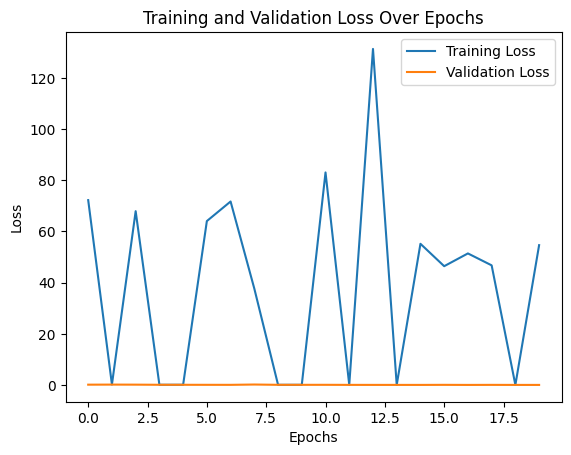

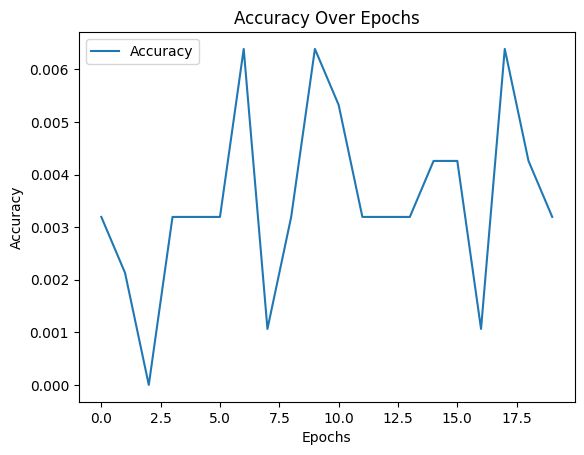

In [18]:
#print()

project_models.lossplot(Trans_tloss, Trans_vloss)
project_models.accplot(Trans_vacc)